In [1]:
import pandas as pd
import numpy as np
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Process the "finalized" master file

In [2]:
master_df = '/Volumes/Seagate/misc/master.csv.gz'
df = pd.read_csv(master_df, compression='gzip', sep='\t')

## Get basefeepergas per curblocknumber

curblocknumber[i] has basefeepergas[i] 

In [3]:
# Get a list of curblocknumber, basefeepergas
curblocknumber = df['curblocknumber'].values
basefeepergas = df['basefeepergas'].values

# zip together the two arrays and remove duplicates
zipped = list(zip(curblocknumber, basefeepergas))
zipped = list(set(zipped))

# sort zipped by curblocknumber
zipped.sort(key=lambda x: x[0])

curblocknumber, basefeepergas = zip(*zipped)

# Check if curblocknumber is monotonic increasing and sequential
curblocknumber = np.array(curblocknumber)
print("Is curblocknumber monotonic increasing?", np.all(np.diff(curblocknumber) > 0))
print("Is curblocknumber sequential (no gaps)?", np.all(np.diff(curblocknumber) == 1))

Is curblocknumber monotonic increasing? True
Is curblocknumber sequential (no gaps)? True


#### Save the arrays curblocknumber and basefeepergas

In [4]:
# store curblocknumber and basefeepergas in pickle file
with open('curblocknumber_basefeepergas.pickle', 'wb') as f:
    pickle.dump((curblocknumber, basefeepergas), f)

## Subset to confirmed and failed events
#### Save the finalized events df in a new file

In [5]:
# file is small at ~1 GB
df = df[(df['status'] == 'confirmed') | (df['status'] == 'failed')]
df.to_csv('finalized.csv.gz', compression='gzip', sep='\t', index=False)

# 2. Load in and initialize data 

I like to close and reopen VS Code at this point and start from here to clear up memory

In [2]:
df = pd.read_csv('finalized.csv.gz', compression='gzip', sep='\t')

# Load the lists of curblocknumber, basefeepergas
with open('curblocknumber_basefeepergas.pickle', 'rb') as f:
    curblocknumber, basefeepergas = pickle.load(f)

### Subset finalized txns to non-private txns (timepending > 0)

In [3]:
df = df[df['timepending'] > 0]

#### Fix column types to int

In [4]:
# convert the column blockspending to integers
df['blockspending'] = df['blockspending'].astype(int)

# convert the column maxfeepergas to integers
df['maxfeepergas'] = df['maxfeepergas'].astype(int)

In [5]:
# keep only the first occurance of duplicate hashes to avoid double+ counting transactions
# an example case of duplicate hash is if a transaction is confirmed, then another block includes it again before it was evicted, so then it fails. To be conservative, we will just not include these duplicates
df = df.drop_duplicates(subset=['hash'], keep='first')

## Initialization

In [6]:
# Includable Gas per Block (GPB)

# initliaze an np array of zeros of the length of curblocknumber
# this will be the GPB array where blocknumber = index + offset
gpb  = np.zeros(len(curblocknumber))    # gas per block (uses column 'gas')
gupb = np.zeros(len(curblocknumber))    # gas used per block (uses column 'gasused')
txns = np.zeros(len(curblocknumber))    # includable transactions per block (increases whenever a transaction is considered includable (MFPG >= BFPB))
offset = curblocknumber[0]

In [7]:
df_len = len(df)

for index, row in df.iterrows():
    # print progress
    if index % 1000 == 0:
        # print("working on row", index, "of", df_len)
        print("\rcheckpoint at row {} of {}".format(index, df_len), end="")

    # get the first block (the block when the transaction is first pending)
    first_block = row['curblocknumber'] - row['blockspending']
    first_block_index = first_block - offset

    # get the last block (the block when the transaction is finalized (confirmed/failed))
    last_block = row['curblocknumber']
    last_block_index = last_block - offset

    # if the first block is negative, set it to 0 (txns that were pending before our sample started but finalized during our sample)
    if first_block_index < 0:
        first_block_index = 0
        
    # for each block that the transaction was pending, if it is includable then add the gas to the GPB array, etc
    for block_index in range(first_block_index, last_block_index+1):
        # if the transaction is includable in the block
        if row['maxfeepergas'] >= basefeepergas[block_index]:
            gpb[block_index] += row['gas']      # add the gas to the GPB array for the block (using column gas)
            gupb[block_index] += row['gasused'] # add the gas used to the GUPB array for the block (using column gasused)
            txns[block_index] += 1              # increment the txns count for the block



checkpoint at row 12009000 of 10217331

In [8]:
# write offset, gpb, gupb, txns to pickle file
with open('includable_arrays.pickle', 'wb') as f:
    pickle.dump((offset, gpb, gupb, txns), f)

In [9]:
includable_df = pd.DataFrame({'Block': curblocknumber, 'GPB': gpb, 'GUPB': gupb, 'TXNS': txns})

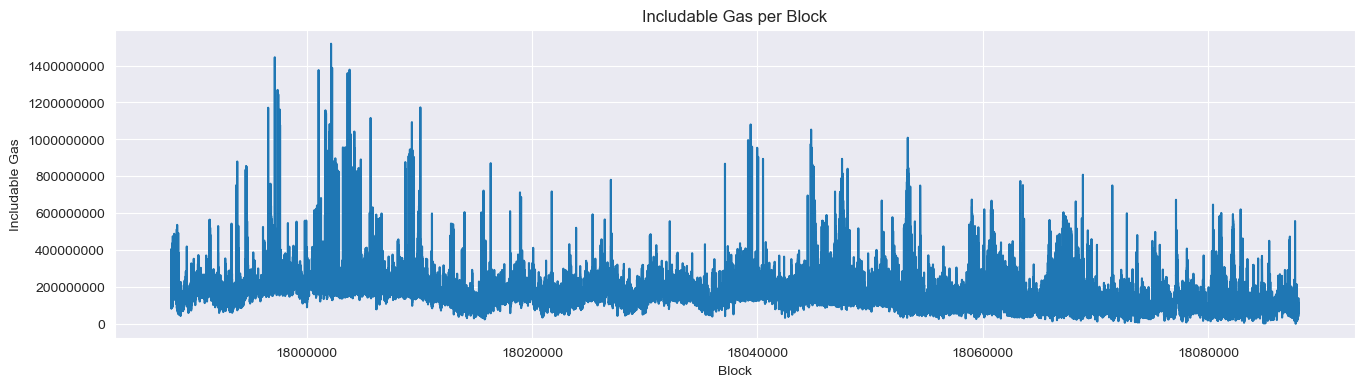

In [10]:
# plot gpb vs curblocknumber
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(curblocknumber, gpb)

plt.title('Includable Gas per Block')
plt.xlabel('Block')
plt.ylabel('Includable Gas')

plt.ticklabel_format(style='plain')

plt.show()


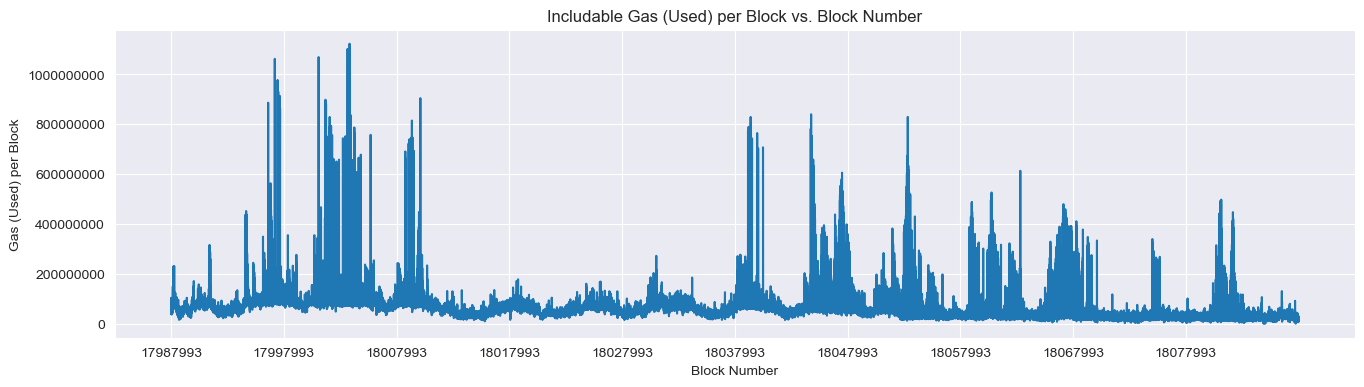

In [11]:
# plot gpb vs curblocknumber
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))
plt.plot(curblocknumber, gupb)
plt.title('Includable Gas (Used) per Block vs. Block Number')
plt.xlabel('Block Number')
plt.ylabel('Gas (Used) per Block')

# use plain text for y axis 
plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')
plt.show()


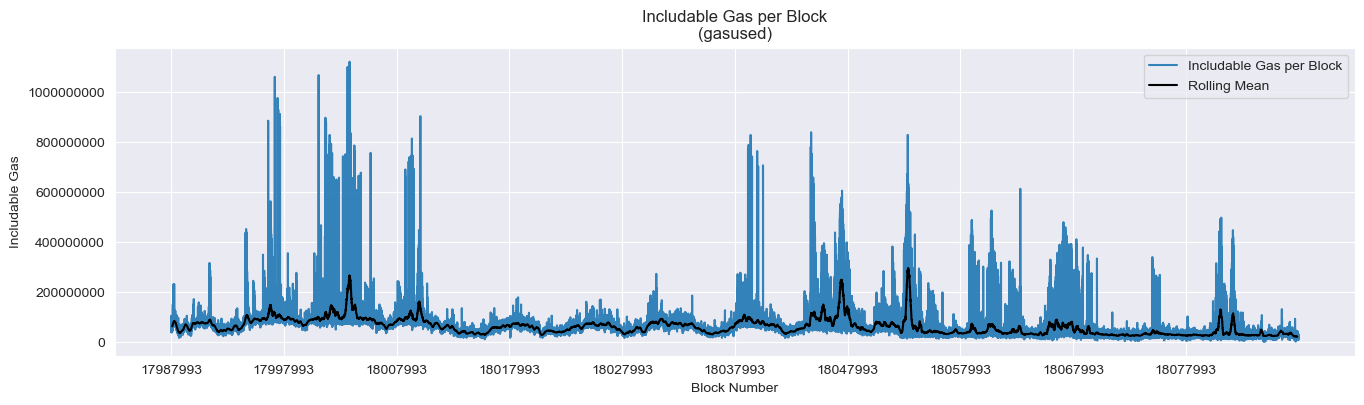

In [17]:
# Calculate the rolling mean
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=200, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))

plt.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas per Block', alpha = 0.9)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Rolling Mean', color='black')

plt.title('Includable Gas per Block\n(gasused)')
plt.xlabel('Block Number')
plt.ylabel('Includable Gas')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

plt.legend()

plt.show()

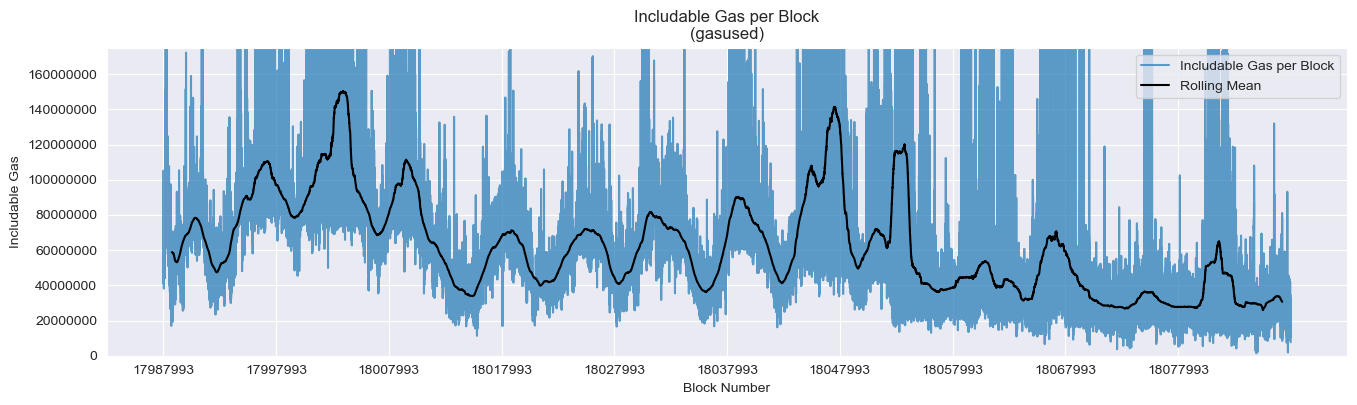

In [19]:
#ZOOM!

includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=1500, center=True).mean()

sns.set_style('darkgrid')
plt.figure(figsize=(16, 4))


plt.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas per Block', alpha=0.7)
plt.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Rolling Mean', color='black')

plt.title('Includable Gas per Block\n(gasused)')
plt.xlabel('Block Number')
plt.ylabel('Includable Gas')

plt.xticks(np.arange(curblocknumber[0], curblocknumber[-1], 10000))
plt.ticklabel_format(style='plain')

plt.ylim(0, 175000000)

plt.legend()

plt.show()

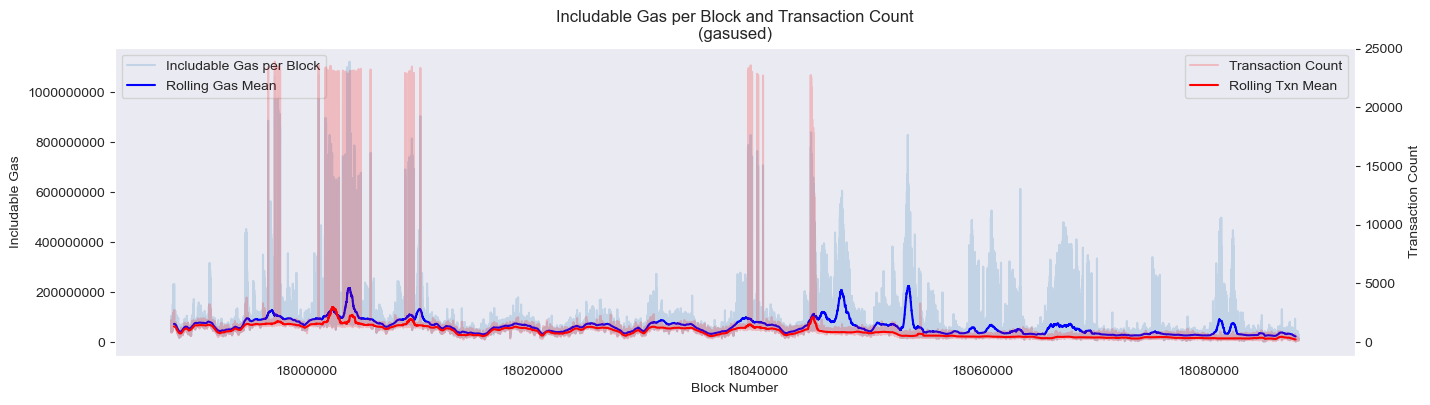

In [21]:
includable_df['Rolling Mean'] = includable_df['GUPB'].rolling(window=500, center=True).mean()

fig, ax1 = plt.subplots(figsize=(16, 4))

sns.set_style('darkgrid', {'axes.grid': False})

ax1.plot(includable_df['Block'], includable_df['GUPB'], label='Includable Gas per Block', alpha = 0.2)
ax1.plot(includable_df['Block'], includable_df['Rolling Mean'], label='Rolling Gas Mean', color='blue')

ax1.set_title('Includable Gas per Block and Transaction Count\n(gasused)')
ax1.set_xlabel('Block Number')
ax1.set_ylabel('Includable Gas')

ax1.ticklabel_format(style='plain')

ax1.legend(loc='upper left')



# Plot the 'Txn Count' on the second y-axis
ax2 = ax1.twinx()

includable_df['Rolling Mean txns'] = includable_df['TXNS'].rolling(window=500, center=True).mean()

ax2.plot(includable_df['Block'], includable_df['TXNS'], label='Transaction Count', color='red', alpha=0.2)
ax2.plot(includable_df['Block'], includable_df['Rolling Mean txns'], label='Rolling Txn Mean', color='red')

ax2.set_ylabel('Transaction Count')
ax2.legend(loc='upper right')

plt.show()